In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
print("Using torch", torch.__version__)
import seaborn as sns
import torchvision.datasets as datasets
from torchvision import transforms
sns.set()
torch.manual_seed(42) # Setting the seed
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

Using torch 2.1.2+cu118


In [2]:
from ac_dll_grammar_vae import print_contact_info
from ac_dll_grammar_vae.data import CFGEquationDataset
from ac_dll_grammar_vae.data.alphabet import alphabet
from ac_dll_grammar_vae.data.transforms import MathTokenEmbedding, RuleTokenEmbedding, ToTensor, Compose, PadSequencesToSameLengthV2, OneHotEncode
from train import *
from eval import *
from visualize import *

Device cuda
Device cuda
Device cuda


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#device = "cpu"

Device cuda


## Character VAE

### Character Embedding:
+ Using Math Token Embedding Class

{'+': 1,
 '-': 2,
 '3': 3,
 'sqrt': 4,
 'exp': 5,
 '(': 6,
 'sin': 7,
 '/': 8,
 'x': 9,
 ')': 10,
 '*': 11,
 'log': 12,
 'cos': 13,
 '2': 14,
 '1': 15,
 ' ': 0}

In [ ]:
emb = MathTokenEmbedding(alphabet=alphabet)
emb.token_to_idx

In [ ]:
#Example Data
data = CFGEquationDataset()
#Example Encoding:
print(f'Example: Data {data[42]}')
encoded_data = emb.embed(data[42])
print(f'Encoded Example: Data {encoded_data}')

+ Example: Data ['cos', '(', '(', '1', ')', ')', '+', '2']
+ Encoded Example: Data [13, 6, 6, 15, 10, 10, 1, 14]

### Creating the Training Dataset using CFG 
 + Class CFGEquationDataset is used to generate the equations

In [ ]:
#Batch Size:
batch_size = 100
MAX_SEQ_LEN = 21

In [ ]:
training = CFGEquationDataset(
        n_samples=100000,
        transform=Compose([
            MathTokenEmbedding(alphabet),
            ToTensor(dtype=torch.uint8)
        ]))
collate_fn = PadSequencesToSameLengthV2(padding_value=0, max_length=21)
training_loader = DataLoader(dataset=training,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=PadSequencesToSameLengthV2(padding_value=0, max_length=21))

#### Convert the Embedded equations into one hot encoded vectors

In [ ]:
onehotencoder = OneHotEncode(alphabet)

In [ ]:

one_hot_encoded_training = []
for batch in training_loader:
  try:
    one_hot_encoded_batch = onehotencoder(batch)
  except Exception as e:
    print(batch)
    continue
  one_hot_encoded_training.append(one_hot_encoded_batch.numpy())
one_hot_encoded_training = np.array(one_hot_encoded_training)
one_hot_encoded_training_tensor = torch.Tensor(one_hot_encoded_training)
one_hot_encoded_training_tensor = one_hot_encoded_training_tensor.view(one_hot_encoded_training_tensor.shape[0]*one_hot_encoded_training_tensor.shape[1],one_hot_encoded_training_tensor.shape[2],one_hot_encoded_training_tensor.shape[3])
one_hot_encoded_training_tensor.shape

### Creating final dataloader for model which is one-hot-encoded:
 + Setting Maximum equation length to 21

In [ ]:
batch_size = 100
MAX_SEQ_LEN = 21
alphabet_length = len(alphabet) + 1
one_hot_encoded_training_loader = DataLoader(dataset=one_hot_encoded_training_tensor,
                              batch_size=batch_size,
                              shuffle=False)

### Creating the Test Dataset and Dataloader:

In [ ]:
test_dataset = CFGEquationDataset(
        n_samples=1000,
        transform=Compose([
            MathTokenEmbedding(alphabet),
            ToTensor(dtype=torch.uint8)
        ]))
#Batch Size:
batch_size = 100
MAX_SEQ_LEN = 21
collate_fn = PadSequencesToSameLengthV2(padding_value=0, max_length=21)
test_loader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=PadSequencesToSameLengthV2(padding_value=0, max_length=21))

In [ ]:
one_hot_encoded_testing = []
for batch in test_loader:
  try:
    one_hot_encoded_batch = onehotencoder(batch)
  except Exception as e:
    print(batch)
    continue
  #print(one_hot_encoded_batch.shape)
  one_hot_encoded_testing.append(one_hot_encoded_batch.numpy())
one_hot_encoded_testing = np.array(one_hot_encoded_testing)
one_hot_encoded_testing_tensor = torch.Tensor(one_hot_encoded_testing)
one_hot_encoded_testing_tensor = one_hot_encoded_testing_tensor.view(one_hot_encoded_testing_tensor.shape[0]*one_hot_encoded_testing_tensor.shape[1],one_hot_encoded_testing_tensor.shape[2],one_hot_encoded_testing_tensor.shape[3])
print(one_hot_encoded_testing_tensor.shape)
one_hot_encoded_testing_loader = DataLoader(dataset=one_hot_encoded_testing_tensor,
                              batch_size=batch_size,
                              shuffle=False)

### Model Initialization for Character AE

In [ ]:
from models import EqnAE
from train import train_AEmodel

In [ ]:
mlflow.end_run()

In [ ]:
import mlflow
from hyperparam_optim import HyperparameterOptimization
from tracking import MLFlowTracker
import itertools
from visualize import visualize_latent_space_Eqn

hyperParamOptimization = HyperparameterOptimization('./hyperparameters/params.yaml')
params = hyperParamOptimization.get_params()

#mlflow.create_experiment('Character AE Equation V1')
mlflow.set_experiment('Character AE Equation V1')


hyperparameter_combinations = itertools.product(params.M_LATENTDIMENSION, params.T_NUMEPOCHS, params.T_LR, params.T_BATCHSIZE, params.T_LOSS, params.T_OPTIMIZER, params.T_TRAINVALIDRATIO)
for combination in hyperparameter_combinations:
    mlflow.start_run()
    latent_dim, num_epochs, lr, batch_size, loss_function, optimizer_name, train_valid_ratio = combination

    # Initialize your model with the given latent dimension
    # Model Initialization
    alphabet_length = len(alphabet) + 1
    MAX_SEQ_LEN = 21
    model = EqnAE(alphabet_length,MAX_SEQ_LEN,latent_rep_size=latent_dim)
    model.to(device)
    #Loss
    if loss_function == 'BCE':
        loss_module = nn.BCELoss(reduction="sum")
    elif loss_function == 'MSE':
        loss_module = nn.MSELoss(reduction="sum")
    
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

    total_samples = one_hot_encoded_training_tensor.shape[0]
    valid_size = int(total_samples * train_valid_ratio)
    train_size = total_samples - valid_size

    train_tensor = one_hot_encoded_training_tensor[:train_size]
    valid_tensor = one_hot_encoded_training_tensor[train_size:]

    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(valid_tensor) 

    train_loader = DataLoader(dataset=train_tensor,
                              batch_size=batch_size,
                              shuffle=False)

    val_loader = DataLoader(dataset=valid_tensor,
                              batch_size=batch_size,
                              shuffle=False)

    # Log parameters to MLflow
    mlflow.log_params({
        "latent_dimension": latent_dim,
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "optimizer": optimizer_name,
        "train_valid_ratio": train_valid_ratio
    })

    train_EqnAE(model, train_loader, val_loader, loss_module, optimizer, num_epochs=num_epochs)

    
    torch.save(model,f'./saved/models/EQN_AE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_Full.pth')
    torch.save(model.state_dict(),f'./saved/models/EQN_AE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_dict.pth')

    # Save the model
    mlflow.pytorch.log_model(model, "model")

    test_tensor = one_hot_encoded_testing_tensor
    test_dataset = TensorDataset(test_tensor)
    test_loader = DataLoader(dataset=test_tensor,
                              batch_size=batch_size,
                              shuffle=False)             
    model.to(device)
    visualize_latent_space_Eqn(model, test_loader,False)
    mlflow.log_artifact("./plots/LatentSpace_plot.png", artifact_path="plots")

    one_hot_decoded = []
    one_hot_decoded_recon = []
    recon_losses = []
    model.eval()
    criterion = torch.nn.BCELoss(reduction='sum')
    for sample in test_loader:
        sample = sample.float().to(device)
        recon = model(sample)
        for idx,ele in enumerate(recon):
            recon_loss = criterion(ele,sample[idx])
            max_indices = torch.argmax(ele, dim=1)
            one_hot = torch.zeros_like(ele) 
            one_hot[torch.arange(ele.size(0)), max_indices] = 1
            embd = torch.argmax(one_hot, dim=1)
            one_hot_decoded.append(emb.decode(torch.argmax(sample[idx], dim=1)))
            one_hot_decoded_recon.append(emb.decode(embd))
            recon_losses.append(recon_loss)
            recon_loss = 0
            #break

        output_filename = f"./output/output_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}.txt"
        with open(output_filename, "w") as file:
            for idx, ele in enumerate(one_hot_decoded_recon[:1000]):
                actual_equation = ''.join(one_hot_decoded[idx])
                decoded_equation = ''.join(one_hot_decode   d_recon[idx])
                file.write(f'Actual Equation: {actual_equation}\n')
                file.write(f'AE Decoded Equation: {decoded_equation}\n')
                file.write(f'AE Reconstruction Loss: {recon_losses[idx]}\n\n')
                

        # Log the file as an artifact in MLflow
        mlflow.log_artifact(output_filename, artifact_path="outputs")

    # End MLflow run
    mlflow.end_run()

In [ ]:
model = torch.load('./saved/models/EQN_AE_25_200_BCE_0.001_15_Adam_0.1_Full.pth')
# test_tensor = one_hot_encoded_testing_tensor
# test_dataset = TensorDataset(test_tensor)
# test_loader = DataLoader(dataset=test_tensor,
#                             batch_size=batch_size,
#                             shuffle=False)             
# model.to(device)
# visualize_latent_space_Eqn_PCA(model, test_loader,False,False,None,n=15,seed=45)
#vis_interpolation(model,test_loader,vae=True)
#return


test_tensor = one_hot_encoded_testing_tensor
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(dataset=test_tensor,
                            batch_size=batch_size,
                            shuffle=False)             
model.to(device)
#visualize_latent_space_Eqn(model, test_loader,False)
#mlflow.log_artifact("./plots/LatentSpace_plot.png", artifact_path="plots")

one_hot_decoded = []
one_hot_decoded_recon = []
recon_loss = []
criterion = torch.nn.BCELoss(reduction='sum')
for sample in test_loader:
    model.eval()
    sample = sample.float().to(device)
    recon = model(sample)
    for idx,ele in enumerate(recon):
        loss = criterion(ele,sample[idx])
        recon_loss.append(loss)
        max_indices = torch.argmax(ele, dim=1)
        one_hot = torch.zeros_like(ele) 
        one_hot[torch.arange(ele.size(0)), max_indices] = 1
        embd = torch.argmax(one_hot, dim=1)
        one_hot_decoded.append(emb.decode(torch.argmax(sample[idx], dim=1)))
        one_hot_decoded_recon.append(emb.decode(embd))

    output_filename = f"./output/output_AE_25_100_BCE_0.001_15_Adam_0.1.txt"
    with open(output_filename, "w") as file:
        for idx, ele in enumerate(one_hot_decoded_recon[:1000]):
            actual_equation = ''.join(one_hot_decoded[idx])
            decoded_equation = ''.join(one_hot_decoded_recon[idx])
            file.write(f'Actual Equation: {actual_equation}\n')
            file.write(f'AE Decoded Equation: {decoded_equation}\n')
            file.write(f'AE Reconstruction Loss: {recon_loss[idx]}\n\n')

### Character VAE Model

In [ ]:
from models import EqnVAE
from train import train_EqnVAE

### Model Initialization and Hyperparameter Optimization for Character VAE

In [ ]:
mlflow.end_run()

In [ ]:
import mlflow
from hyperparam_optim import HyperparameterOptimization
from tracking import MLFlowTracker
import itertools
from visualize import visualize_latent_space_Eqn
import gc
import time

hyperParamOptimization = HyperparameterOptimization('./hyperparameters/params.yaml')
params = hyperParamOptimization.get_params()

#mlflow.create_experiment('Character VAE Equation V2')
mlflow.set_experiment('Character VAE Equation V2')

hyperparameter_combinations = itertools.product(params.M_LATENTDIMENSION, params.T_NUMEPOCHS, params.T_LR, params.T_BATCHSIZE, params.T_LOSS, params.T_OPTIMIZER, params.T_TRAINVALIDRATIO)
for i,combination in enumerate(hyperparameter_combinations):
    # if i <= 1:
    #     continue
    mlflow.start_run()
    latent_dim, num_epochs, lr, batch_size, loss_function, optimizer_name, train_valid_ratio = combination

    # Initialize your model with the given latent dimension
    # Model Initialization
    alphabet_length = len(alphabet) + 1
    MAX_SEQ_LEN = 21
    model = None
    model = EqnVAE(alphabet_length,MAX_SEQ_LEN,latent_rep_size=latent_dim,recon_loss=loss_function)
    model.to(device)
    #Loss
    vaeLoss = None
    vaeLoss = model.vae_loss
    optimizer = None
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

    total_samples = one_hot_encoded_training_tensor.shape[0]
    valid_size = int(total_samples * train_valid_ratio)
    train_size = total_samples - valid_size

    train_tensor = one_hot_encoded_training_tensor[:train_size].clone().to(device)
    valid_tensor = one_hot_encoded_training_tensor[train_size:].clone().to(device)
    train_loader, val_loade = None, None
    train_loader = DataLoader(dataset=train_tensor,
                              batch_size=batch_size,
                              shuffle=False)

    val_loader = DataLoader(dataset=valid_tensor,
                              batch_size=batch_size,
                              shuffle=False)

    # Log parameters to MLflow
    mlflow.log_params({
        "latent_dimension": latent_dim,
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "optimizer": optimizer_name,
        "train_valid_ratio": train_valid_ratio
    })

    train_EqnVAE(model, train_loader, val_loader, vaeLoss, optimizer, num_epochs=num_epochs)

    
    torch.save(model,f'./saved/models/EQN_VAE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_Full.pth')
    torch.save(model.state_dict(),f'./saved/models/EQN_VAE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_dict.pth')

    # Save the model
    mlflow.pytorch.log_model(model, "model")

    test_tensor = one_hot_encoded_testing_tensor.clone().to(device)
    test_dataset = TensorDataset(test_tensor)
    test_loader = DataLoader(dataset=test_tensor,
                              batch_size=batch_size,
                              shuffle=False)             
    model.to(device)
    visualize_latent_space_Eqn(model, test_loader,True)
    mlflow.log_artifact("./plots/LatentSpace_plot.png", artifact_path="plots")

    one_hot_decoded = []
    one_hot_decoded_recon = []
    recon_losses = []
    model.eval()
    criterion = torch.nn.BCELoss(reduction='sum')
    for sample in test_loader:
        sample = sample.float().to(device)
        recon, _, _ = model(sample)
        for idx,ele in enumerate(recon):
            recon_loss = criterion(ele,sample[idx])
            max_indices = torch.argmax(ele, dim=1)
            one_hot = torch.zeros_like(ele) 
            one_hot[torch.arange(ele.size(0)), max_indices] = 1
            embd = torch.argmax(one_hot, dim=1)
            one_hot_decoded.append(emb.decode(torch.argmax(sample[idx], dim=1)))
            one_hot_decoded_recon.append(emb.decode(embd))
            recon_losses.append(recon_loss)
            recon_loss = 0

        output_filename = f"./output/output_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}.txt"
        with open(output_filename, "w") as file:
            for idx, ele in enumerate(one_hot_decoded_recon[:1000]):
                actual_equation = ''.join(one_hot_decoded[idx])
                decoded_equation = ''.join(one_hot_decoded_recon[idx])
                file.write(f'Actual Equation: {actual_equation}\n')
                file.write(f'VAE Decoded Equation: {decoded_equation}\n')
                file.write(f'VAE Reconstruction Loss: {recon_losses[idx]}\n\n')

        # Log the file as an artifact in MLflow
        mlflow.log_artifact(output_filename, artifact_path="outputs")

    
    # Clear memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear cached memory
        torch.cuda.manual_seed_all(42)  # Re-seed

    # Wait for 5-10 seconds before the next run
    
    # End MLflow run
    mlflow.end_run()
    time.sleep(5)  # Sleep for 5 seconds

## Grammar VAE

### Embed Equations to Rule

In [4]:
#Rules Embedding
data = CFGEquationDataset()
cfg = data.get_grammar()
emb = RuleTokenEmbedding(cfg=cfg,one_hot_encode=True)
emb.rule_to_idx
emb.idx_to_rule

{0: "S -> S '+' T",
 1: "S -> S '*' T",
 2: "S -> S '/' T",
 3: "S -> S '-' T",
 4: 'S -> T',
 5: "T -> '(' S ')'",
 6: "T -> 'sin' '(' S ')'",
 7: "T -> 'exp' '(' S ')'",
 8: "T -> 'cos' '(' S ')'",
 9: "T -> 'sqrt' '(' S ')'",
 10: "T -> 'log' '(' S ')'",
 11: "T -> 'x'",
 12: "T -> '1'",
 13: "T -> '2'",
 14: "T -> '3'",
 15: "Nothing -> 'None'"}

### Intializing Grammar Masks and Mask Index for Introducing into Model

In [5]:
import nltk
# Parsing the grammar to create masks and indices
all_lhs = [a.lhs().symbol() for a in cfg.productions()]
lhs_list = []
for a in all_lhs:
    if a not in lhs_list:
        lhs_list.append(a)
D = len(cfg.productions())

rhs_map = [None] * D
for i, production in enumerate(cfg.productions()):
    rhs_map[i] = [lhs_list.index(b.symbol()) for b in production.rhs() if (isinstance(b, nltk.Nonterminal) and b.symbol()!='None')]

print(rhs_map)

masks = np.zeros((len(lhs_list), D))
for i, lhs in enumerate(lhs_list):
    masks[i] = [lhs == production.lhs().symbol() for production in cfg.productions()]

print(masks)
ind_of_ind = np.array([np.where(masks[:, i] == 1)[0][0] for i in range(masks.shape[1])])
print(ind_of_ind)
# Convert numpy arrays to torch tensors
masks_tensor = torch.from_numpy(masks).float()
ind_of_ind_tensor = torch.from_numpy(ind_of_ind).long()

[[0, 1], [0, 1], [0, 1], [0, 1], [1], [0], [0], [0], [0], [0], [0], [], [], [], [], []]
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2]


#### Example Encoding of an equation

In [6]:
eqn = ['sqrt','(','log','(','x','*','cos','(','2',')',')',')','*','x']
encoded_gram_eqn = emb.embed(eqn)
encoded_gram_eqn


[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.

### Grammar VAE Initialization

In [7]:
num_rules = len(cfg.productions())
num_rules

16

In [8]:
from models import EqnGVAE
from train import train_EqnGVAE

Device cuda


### Data Preparation for GVAE

In [9]:
training_val_gvae_dataset = CFGEquationDataset(
        n_samples=100000,
        transform=Compose([
            RuleTokenEmbedding(cfg,max_num_rules=16,one_hot_encode=True),
            ToTensor(dtype=torch.uint8)
        ]))

#Batch Size:
batch_size = 100
MAX_PROD_LEN = 16

test_gvae_dataset = CFGEquationDataset(
        n_samples=10000,
        transform=Compose([
            RuleTokenEmbedding(cfg,max_num_rules=16,one_hot_encode=True),
            ToTensor(dtype=torch.uint8)
        ]))


#### Training of GVAE

In [10]:
from eval import *


In [11]:
mlflow.end_run()

(10000, 25)
[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924, 5574, 4552, 2547, 3527, 5514, 1674, 1519, 6224, 1584, 5881, 5635, 9891, 4333, 711, 7527, 8785, 2045, 6201, 1291, 9044]


c:\Users\soupt\OneDrive - stud.uni-stuttgart.de\AI LAB\Project\Repo\visualize.py:135: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


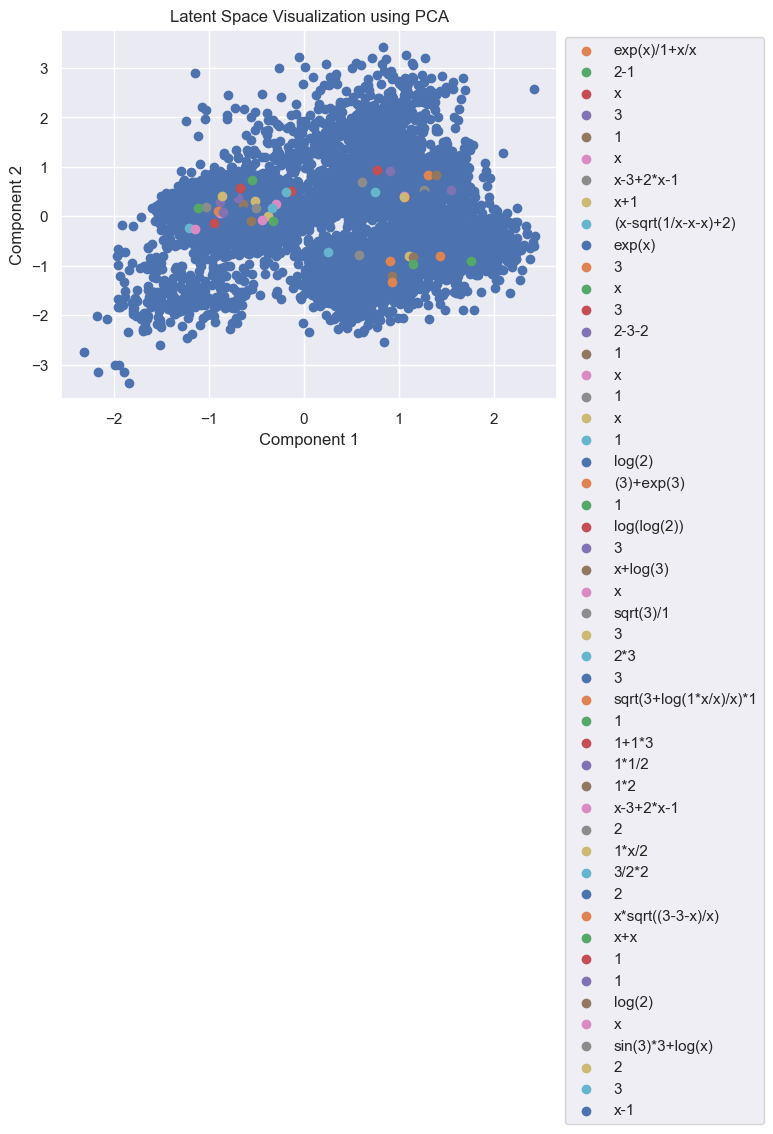

KeyboardInterrupt: 

In [12]:
import mlflow
from hyperparam_optim import HyperparameterOptimization
from tracking import MLFlowTracker
import itertools
from visualize import visualize_latent_space_Eqn
import gc
import time
from torch.utils.data import random_split

hyperParamOptimization = HyperparameterOptimization('./hyperparameters/params.yaml')
params = hyperParamOptimization.get_params()

#mlflow.create_experiment('Character VAE Equation V2')
mlflow.set_experiment('Grammar VAE Equation V1')

hyperparameter_combinations = itertools.product(params.M_LATENTDIMENSION, params.T_NUMEPOCHS, params.T_LR, params.T_BATCHSIZE, params.T_LOSS, params.T_OPTIMIZER, params.T_TRAINVALIDRATIO)
for i,combination in enumerate(hyperparameter_combinations):
    # if i <= 1:
    #     continue
    mlflow.start_run()
    latent_dim, num_epochs, lr, batch_size, loss_function, optimizer_name, train_valid_ratio = combination

    # Initialize your model with the given latent dimension
    # Model Initialization
    model = None
    model = EqnGVAE(num_rules,MAX_PROD_LEN,masks_tensor=masks_tensor,ind_of_masks=ind_of_ind_tensor)
    model.to(device)
    #Loss
    vaeLoss = None
    vaeLoss = model.vae_loss
    optimizer = None
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)



    total_samples = len(training_val_gvae_dataset)
    valid_size = int(total_samples * train_valid_ratio)
    train_size = total_samples - valid_size

    train_dataset, valid_dataset = random_split(training_val_gvae_dataset, [train_size, valid_size])
    train_loader, val_loader = None, None
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    # Log parameters to MLflow
    mlflow.log_params({
        "latent_dimension": latent_dim,
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "optimizer": optimizer_name,
        "train_valid_ratio": train_valid_ratio
    })

    train_EqnGVAE(model, train_loader, val_loader, vaeLoss, optimizer, num_epochs=1)

    
    torch.save(model,f'./saved/models/EQN_GVAE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_Full.pth')
    torch.save(model.state_dict(),f'./saved/models/EQN_GVAE_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}_dict.pth')

    # Save the model
    mlflow.pytorch.log_model(model, "model")

    test_dataset = test_gvae_dataset
    test_loader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False)             
    model.to(device)

    test_loss = eval_modelVAEEquations(model,test_loader,vaeLoss)
    mlflow.log_metric("Validation Loss", test_loss)

    #visualize_latent_space_EqnGVAE(model,test_loader,max_num_rules=16,cfg=cfg,vae=True)
    visualize_latent_space_Eqn_PCA(model, test_loader,True,True,cfg,n=30)
    mlflow.log_artifact("./plots/PCA_LatentSpace_plot.png", artifact_path="plots")

   
    equations_rules_decoded, equations_rules_actual, recon_losses = sample_fromGVAE(model,test_loader,masks_tensor,ind_of_ind_tensor,max_length=16,num_rules=16,emb=emb)

    output_filename = f"./output/output_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}.txt"
    with open(output_filename, "w") as file:
        for idx, rule_decoded in enumerate(equations_rules_decoded):
            file.write(f'Actual Equation Rules: {equations_rules_actual[idx]}\n')
            file.write(f'GVAE Decoded Equation Rules: {rule_decoded}\n')
            file.write(f'Recontruction Loss: {recon_losses[idx]}\n\n')

    mlflow.log_artifact(output_filename, artifact_path="outputs")
    
    output_filename = f"./output/output_rule_{latent_dim}_{batch_size}_{loss_function}_{lr}_{num_epochs}_{optimizer_name}_{train_valid_ratio}.txt"
    with open(output_filename, "w") as file:
        for idx, ele in enumerate(equations_rules_decoded):
            actual_equation = ''.join(emb_dec.decode_from_sampled_rules(equations_rules_actual[idx]))
            decoded_equation = ''.join(emb_dec.decode_from_sampled_rules(ele))
            file.write(f'Actual Equation: {actual_equation}\n')
            file.write(f'GVAE Decoded Equation: {decoded_equation}\n')
            file.write(f'Recontruction Loss: {recon_losses[idx]}\n\n')

        # Log the file as an artifact in MLflow
    mlflow.log_artifact(output_filename, artifact_path="outputs")

    
    # Clear memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear cached memory
        torch.cuda.manual_seed_all(42)  # Re-seed

    # Wait for 5-10 seconds before the next run
    
    # End MLflow run
    mlflow.end_run()
    time.sleep(5)  # Sleep for 5 seconds

In [ ]:
model_GVAE = torch.load('./saved/models/EQN_GVAE_25_200_BCE_0.001_30_Adam_0.1_Full.pth')

In [ ]:
test_dataset = test_gvae_dataset
test_loader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False)   

In [ ]:

equations_rules_decoded, equations_rules_actual, recon_losses = sample_fromGVAE(model_GVAE,test_loader,masks_tensor,ind_of_ind_tensor,max_length=16,num_rules=16,emb=emb)

In [ ]:
emb_dec = RuleTokenEmbedding(cfg=cfg,one_hot_encode=False)
output_filename = f"./output/output_rule_GVAE_{25}_200_BCE_0.001_30_Adam_0.1.txt"
with open(output_filename, "w") as file:
    for idx, rule_decoded in enumerate(equations_rules_decoded):
        file.write(f'Actual Equation Rules: {equations_rules_actual[idx]}\n')
        file.write(f'GVAE Decoded Equation Rules: {rule_decoded}\n')
        file.write(f'Recontruction Loss: {recon_losses[idx]}\n\n')
output_filename = f"./output/output_GVAE_{25}_200_BCE_0.001_30_Adam_0.1.txt"
with open(output_filename, "w") as file:
    for idx, ele in enumerate(equations_rules_decoded):
        actual_equation = ''.join(emb_dec.decode_from_sampled_rules(equations_rules_actual[idx]))
        decoded_equation = ''.join(emb_dec.decode_from_sampled_rules(ele))
        file.write(f'Actual Equation: {actual_equation}\n')
        file.write(f'GVAE Decoded Equation: {decoded_equation}\n')
        file.write(f'Recontruction Loss: {recon_losses[idx]}\n\n')

In [ ]:
model_GVAE.to(device)
visualize_latent_space_Eqn_PCA(model_GVAE, test_loader,True,True,cfg,n=50)
#vis_interpolation(model,test_loader,vae=True)